In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from nltk.tokenize import sent_tokenize, word_tokenize
from textblob import TextBlob
from surprise import SVD
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import train_test_split
import gc
from surprise import accuracy
from surprise.model_selection import cross_validate
from surprise.model_selection import GridSearchCV

### IMPORTACION DE DATASET

In [2]:
import gzip
import pandas as pd

def parse(path):
    g = gzip.open(path, 'r')
    for l in g:
        yield eval(l)

In [3]:
#contador = 0
#data_reviews = []
# Vamos a guardar una de cada 10 reviews para no llenar la memoria RAM. Si pones n = 3, 
# abrira uno de cada tres, y asi.
#n = 3
#for l in parse('C:\\Users\\Usuario\\source\\repos\\steam_reviews.json.gz'):
#    if contador%n == 0:
#        data_reviews.append(l)
#    else:
 #         pass
 #         contador += 1
    
 


In [4]:
data_games = []
for l in parse('C:\\Users\\Usuario\\source\\repos\\steam_games.json.gz'):
        data_games.append(l)

In [5]:
#data_reviews = pd.DataFrame(data_reviews)
#data_reviews.drop('Unnamed: 0',axis=1,inplace=True)


In [6]:
#data_reviews.to_csv('C:\\Users\\Usuario\\source\\repos\\data_reviews.csv')
#del data_reviews

In [7]:
data_reviews= pd.read_csv('C:\\Users\\Usuario\\source\\repos\\data_reviews.csv')


In [8]:
data_reviews.drop('Unnamed: 0', axis=1,inplace=True)

In [9]:
data_games = pd.DataFrame(data_games)

### DESCRIPCIÓN DE FEATURES DATA_REVIEWS

**username:** Nombre del usuario que ha dejado la reseña

**hours:** Cantidad de horas jugadas (acumuladas) en el juego al cual se le ha hecho la reseña

**products:** Cantidad de otros juegos probados

**product_id:** Identificacion númerica del juego reseñado

**page_order:** Número de página en el cual se encuentra el juego dentro de la plataforma

**date:** Fecha en la cual se ha creado la reseña

**text:** Comentario sobre el juego

**early_access:** Si es True significa que el juego puede ser adquirido durante su etapa de desarrollo

**page:** No es interpretable

**user_id:** Identificacion númerica del usuario creador de la reseña

**found_funny:** Cantidad de calificaciones positivas creadas por otros usuarios

**compensation:** Variable no interpretable dada la cantidad de valores nulos contenidos en ella


In [10]:
data_games.head()

,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore
0,Kotoshiro,"[Action, Casual, Indie, Simulation, Strategy]",Lost Summoner Kitty,Lost Summoner Kitty,http://store.steampowered.com/app/761140/Lost_...,2018-01-04,"[Strategy, Action, Indie, Casual, Simulation]",4.49,http://steamcommunity.com/app/761140/reviews/?...,[Single-player],4.99,False,761140,Kotoshiro,NaN,NaN
1,"Making Fun, Inc.","[Free to Play, Indie, RPG, Strategy]",Ironbound,Ironbound,http://store.steampowered.com/app/643980/Ironb...,2018-01-04,"[Free to Play, Strategy, Indie, RPG, Card Game...",NaN,http://steamcommunity.com/app/643980/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",Free To Play,False,643980,Secret Level SRL,Mostly Positive,NaN
2,Poolians.com,"[Casual, Free to Play, Indie, Simulation, Sports]",Real Pool 3D - Poolians,Real Pool 3D - Poolians,http://store.steampowered.com/app/670290/Real_...,2017-07-24,"[Free to Play, Simulation, Sports, Casual, Ind...",NaN,http://steamcommunity.com/app/670290/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",Free to Play,False,670290,Poolians.com,Mostly Positive,NaN
3,彼岸领域,"[Action, Adventure, Casual]",弹炸人2222,弹炸人2222,http://store.steampowered.com/app/767400/2222/,2017-12-07,"[Action, Adventure, Casual]",0.83,http://steamcommunity.com/app/767400/reviews/?...,[Single-player],0.99,False,767400,彼岸领域,NaN,NaN
4,NaN,NaN,Log Challenge,NaN,http://store.steampowered.com/app/773570/Log_C...,NaN,"[Action, Indie, Casual, Sports]",1.79,http://steamcommunity.com/app/773570/reviews/?...,"[Single-player, Full controller support, HTC V...",2.99,False,773570,NaN,NaN,NaN


### DESCRIPCIÓN DE FEATURES INCLUIDOS EN DATA_GAMES

**desarrollador:** Creador del juego

**genres:** Géneros, caracteristicas del juego

**app_name:** Editor del juego

**title:** Nombre del juego

**url:** Dirección web donde encontrarlo

**release_date:** Fecha de lanzamiento

**tags:** Etiquetas relacionadas con el juego

**discount_price:** Precio con descuento incluido

**reviews_url:** Dirección web donde encontrar las reseñas sobre el juego

**specs:** Especificaciones

**price:** Precio sin descuento

**early_access:** Si es True significa que el juego puede ser adquirido durante su etapa de desarrollo

**id:** Identificacion númerica del juego publicado

**sentiment:** Emoción promedio generada en los usuarios

**metascore:** Puntaje promedio recibido por los usuarios


### ANALISIS EXPLORATORIO DATA_REVIEWS

In [11]:
data_reviews.head()

,username,hours,products,product_id,page_order,date,text,early_access,page,found_funny,compensation,user_id
0,Chaos Syren,0.1,41.0,725280,0,2017-12-17,This would not be acceptable as an entertainme...,False,1,NaN,NaN,NaN
1,₮ʜᴇ Wᴀʀᴛᴏɴ,51.1,769.0,328100,0,2017-12-27,looks like a facebook game,False,1,NaN,NaN,NaN
2,hello?<,14.6,2.0,328100,1,2017-10-16,Better than Minecraft,False,1,2.0,Product received for free,NaN
3,Cyderine916,5.0,64.0,35140,0,2018-01-04,I love and idolized Batman and this game is Ma...,False,1,NaN,NaN,NaN
4,DarklyThinking,16.6,577.0,35140,1,2018-01-04,Still worth playing in 2018.\nProbably my favo...,False,1,NaN,NaN,7.656120e+16


Cantidad de filas y columnas

In [12]:
data_reviews.shape

(7793069, 12)

Información del tipo de dato contenido en cada feature

In [13]:
data_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7793069 entries, 0 to 7793068
Data columns (total 12 columns):
 #   Column        Dtype  
---  ------        -----  
 0   username      object 
 1   hours         float64
 2   products      float64
 3   product_id    int64  
 4   page_order    int64  
 5   date          object 
 6   text          object 
 7   early_access  bool   
 8   page          int64  
 9   found_funny   float64
 10  compensation  object 
 11  user_id       float64
dtypes: bool(1), float64(4), int64(3), object(4)
memory usage: 661.5+ MB


In [14]:
data_reviews.username.unique()

array(['Chaos Syren', '₮ʜᴇ Wᴀʀᴛᴏɴ', 'hello?<', ..., 'vinao bala tronxa',
       'niquarn', 'Evorix'], dtype=object)

Estadisticos de las variables númericas que contribuyen a definir la calificación del usuario

In [15]:
data_reviews.loc[:,['hours','products']].describe().round(2)

,hours,products
count,7766532.00,7778108.00
mean,111.84,236.48
std,392.86,485.79
min,0.00,1.00
25%,4.00,45.00
50%,15.30,110.00
75%,59.70,246.00
max,42100.70,18188.00


De los estadisticos obtenidos podemos decir que la base de datos contiene valores outlier o que carecen de sentido, mas abajo grafico la ditribución de los features "hours" y "products" con el fin de visualizar la afirmación aquí contenida.

Valores nulos contenidos en cada feature

In [16]:
data_reviews.isna().sum()

username            208
hours             26537
products          14961
product_id            0
page_order            0
date                  0
text              17972
early_access          0
page                  0
found_funny     6592313
compensation    7647446
user_id         4616846
dtype: int64

In [17]:
data_reviews2=data_reviews[(data_reviews.products>10) & (data_reviews.products<300)]
data_reviews2=data_reviews2[(data_reviews2.hours>4) & (data_reviews2.hours<500)]
del data_reviews

In [18]:
data_reviews2.shape

(4093293, 12)

In [19]:
data_reviews2.isna().sum()

username            127
hours                 0
products              0
product_id            0
page_order            0
date                  0
text               7762
early_access          0
page                  0
found_funny     3534713
compensation    4029187
user_id         2259204
dtype: int64

In [32]:
indices_vacios=data_reviews2[data_reviews2.username.isna()].index
indices_vacios

Int64Index([  53571,   96741,  109254,  143132,  143425,  170705,  183052,
             183278,  274769,  315025,
            ...
            7402740, 7423625, 7423808, 7436788, 7450747, 7505290, 7534191,
            7586381, 7632576, 7632725],
           dtype='int64', length=127)

In [36]:
data_reviews2.drop(indices_vacios,inplace=True)

Filtro el dataset quitando aquellos features que considero no van a ser útiles para el modelo

In [51]:
text_vacio=data_reviews2[data_reviews2.text.isna()].index

In [52]:
data_reviews2.drop(text_vacio,inplace=True)

In [59]:
data_reviews2.reset_index(drop=True,inplace=True)

In [61]:
data_reviews3=data_reviews2.loc[:,['username','hours','products','product_id','text']]
data_reviews3.isna().sum()
del data_reviews2

Visualización de la distribución de la variable "hours"

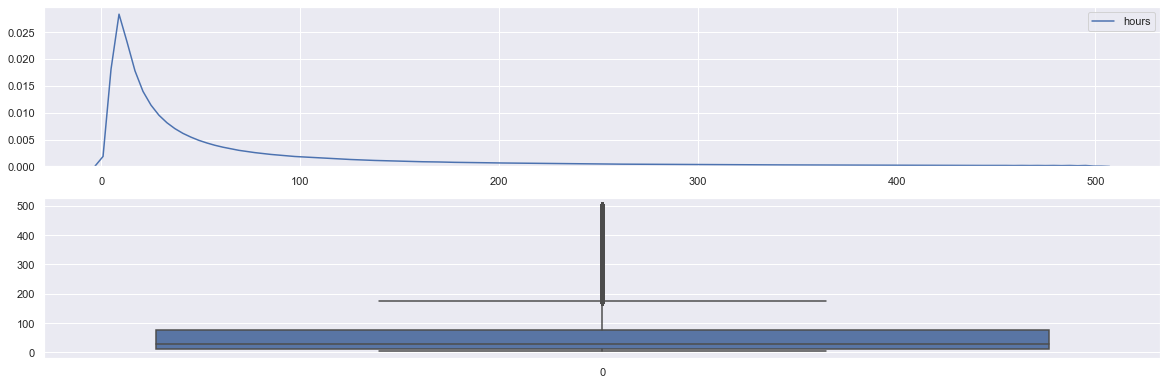

In [62]:

plt.figure(figsize=(20, 10))


plt.subplot(3,1,1)
sns.kdeplot(data=data_reviews3.hours)

plt.subplot(3,1,2)
sns.boxplot(data=data_reviews3.hours)

Visualización de la distribución de la variable "products"

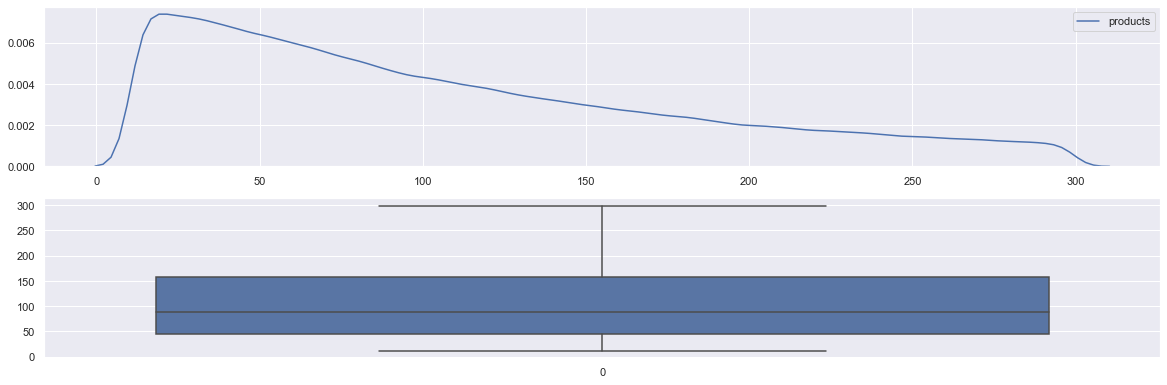

In [64]:
plt.figure(figsize=(20, 10))

plt.subplot(3,1,1)
sns.kdeplot(data=data_reviews3.products)

plt.subplot(3,1,2)
sns.boxplot(data=data_reviews3.products)

Polarity is float which lies in the range of [-1,1] where 1 means positive statement and -1 means a negative statement. Subjective sentences generally refer to personal opinion, emotion or judgment whereas objective refers to factual information. Subjectivity is also a float which lies in the range of [0,1].

In [71]:
polarity_list=[]
for i in range(len(data_reviews3.text)):
    frase=TextBlob(data_reviews3.text[i])
    polarity=frase.sentiment.polarity
    polarity_list.append(polarity)

In [72]:
data_reviews3['Polarity']=pd.Series(polarity_list)

In [74]:
data_reviews3.to_csv('C:\\Users\\Usuario\\source\\repos\\data_reviews4.csv')
del data_reviews3

In [75]:
data_reviews4= pd.read_csv('C:\\Users\\Usuario\\source\\repos\\data_reviews4.csv')

In [76]:
data_reviews4.head()

,Unnamed: 0,username,hours,products,product_id,text,Polarity,Subjectivity
0,0,Cyderine916,5.0,64.0,35140,I love and idolized Batman and this game is Ma...,0.050000,0.500000
1,1,MR_SERENITY,14.8,147.0,35140,aweosme game great story and some epic moments...,0.375000,0.637500
2,2,Coby,8.9,227.0,35140,Finished the game around 6 hours. Thats only t...,0.066667,0.800000
3,3,Duha Nubie,11.3,73.0,35140,first debut feel sweet,0.300000,0.491667
4,4,The Undead StalkeR,17.0,87.0,35140,9/10\nEven after all these years. this game re...,0.471429,0.492857


In [31]:
correlacion=data_reviews2.corr()

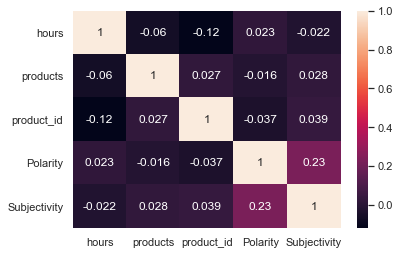

In [32]:
sns.heatmap(correlacion, cbar = True,annot = True)

##Explicar

In [33]:
data_reviews2.describe()

,hours,products,product_id,Polarity,Subjectivity
count,77314.000000,77314.000000,77314.000000,77314.000000,77314.000000
mean,113.439038,235.072833,251667.819347,0.103110,0.467838
std,395.558966,470.833055,150369.137429,0.275693,0.224914
min,0.000000,1.000000,10.000000,-1.000000,0.000000
25%,4.000000,46.000000,203635.000000,-0.003722,0.393056
50%,15.400000,111.000000,252490.000000,0.075000,0.500000
75%,59.575000,246.000000,346110.000000,0.230769,0.594619
max,18543.300000,11222.000000,763410.000000,1.000000,1.000000


Criterio determinacion de Score: **Si la cantidad de productos está dentro de los valores del primer cuartil y la cantidad de horas jugadas está en el 3er cuartil---> Calificación positiva (corroborado con el indice de polaridad)

**Si la cantidad de productos está dentro de los valores del tercer cuartil y la cantidad de horas jugadas está en el 1er cuartil---> Calificación negativa (corroborado con el índice de polaridad)



In [34]:
positive_mask= (data_reviews2.hours>59.75) & (data_reviews2.products<46)


In [35]:

data_reviews2[positive_mask].Polarity.mean()

0.13117870234093953

El resultado obtenido es considerado suficiente para determinar como minimo de polaridad con la que un usuario calificaría como positivo al juego ya que, 0.13 es mayor al promedio de polaridad y, dado que la polaridad es un número que oscila entre -1 y 1 siendo -1 negativo y 1 positvo, el valor obtenido se encuentra mas cercano al extremo positivo que al extremo negativo

In [36]:
negative_mask=(data_reviews2.hours<4) & (data_reviews2.products>246)

In [37]:
data_reviews2[negative_mask].Polarity.mean()

0.0567740481140225

In [38]:
undefined_mask=(data_reviews2.Polarity<0.13117870234093953) & (data_reviews2.Polarity>0.0567740481140225)

In [39]:
data_reviews2[undefined_mask]

,username,hours,products,product_id,text,Polarity,Subjectivity
9,stazboy,8.1,148.0,350280,Make it free to play such a fun game needs people,0.075000,0.475000
12,SOL Ranger,61.2,229.0,399660,As a big fan of C&C Generals it had initial po...,0.066935,0.539405
14,torrent of a goose,14.8,225.0,365560,"well, i m still only into the second day of th...",0.092899,0.580745
15,B A R A B A J A G A L,0.7,291.0,574640,I wasn't expecting too much but I was pleasant...,0.120000,0.511429
23,Rustü,22.5,448.0,531780,Even though I recieved this game for free and ...,0.066453,0.537778
...,...,...,...,...,...,...,...
77275,Big Hutch,4.6,290.0,252490,"This game is really early development, but if ...",0.097143,0.347143
77276,Big Hutch,4.6,290.0,252490,"This game is really early development, but if ...",0.097143,0.347143
77280,Deityrob,26.4,241.0,252490,""".... It's in our interest to make the game aw...",0.066667,0.600000
77300,Offline Soup Man,3.8,79.0,252490,I would wait a lot longer before buying this g...,0.082396,0.562301


In [40]:
data_reviews2.shape

(77314, 7)

In [41]:
9882/77314

0.12781643686783764

In [42]:
def conditions(data):
    if (data['Polarity'] > 0.13117870234093953):
        return 3
    elif (data['Polarity'] < 0.0567740481140225):
        return 1
    else:
        return 2

In [43]:
data_reviews2['Calif'] = data_reviews2.apply(conditions, axis=1)

In [44]:
data_reviews2.username.value_counts()

Alex                28
Chris               24
123                 24
Jack                18
Nick                17
                    ..
salaMander           1
RocketBoy            1
SS MAX 🍰             1
Grape                1
amosh ༼ つ ◕_◕ ༽つ     1
Name: username, Length: 71082, dtype: int64

In [45]:
a=pd.DataFrame({'id':data_reviews_ok.product_id.unique()})
a

NameError: name 'data_reviews_ok' is not defined

### ANALISIS EXPLORATORIO DATA_GAMES

In [79]:
data_games2=data_games.loc[:,['id','title']]

In [80]:
data_games2

,id,title
0,761140,Lost Summoner Kitty
1,643980,Ironbound
2,670290,Real Pool 3D - Poolians
3,767400,弹炸人2222
4,773570,NaN
...,...,...
32130,773640,Colony On Mars
32131,733530,LOGistICAL: South Africa
32132,610660,Russian Roads
32133,658870,EXIT 2 - Directions


In [65]:
data_games2[data_games2.id.isna()]

,id,title
74,NaN,NaN
30961,NaN,Batman: Arkham City - Game of the Year Edition


In [66]:
#data_games2.title.fillna('buscar_valor',inplace=True)

In [67]:
#data_games2.id.fillna(0000,inplace=True)

In [127]:
data_games2.id=pd.to_numeric(data_games2.id,downcast='integer')

In [69]:
#data_reviews2[data_reviews2.product_id==764110]

### SISTEMA DE RECOMENDACION

In [156]:
reader=Reader()

In [157]:
data=Dataset.load_from_df(data_reviews2[['username','product_id','Calif']],reader=reader)

In [158]:
trainset,testset=train_test_split(data,test_size=.3)

In [159]:
algo=SVD()

In [160]:
algo.fit(trainset)

In [161]:
prediction=algo.test(testset)

In [162]:
usuario='Alex'

In [163]:
data_reviews_ok=data_reviews2.loc[:,['username','Calif','product_id']]

In [164]:
df_usuario=data_reviews_ok[data_reviews_ok["username"]==usuario]

In [165]:
df_usuario.reset_index(drop=True,inplace=True)

In [166]:
df_usuario=pd.merge(left=df_usuario,right=data_games2, left_on='product_id', right_on='id')
df_usuario.drop(['id'],inplace=True,axis=1)

In [173]:
df_usuario['Score_model']=df_usuario['product_id'].apply(lambda x: algo.predict(usuario,x).est)

In [174]:
df_usuario

,username,Calif,product_id,title,Score_model
0,Alex,1,531960,Bloody Walls,1.856834
1,Alex,3,225080,Brothers - A Tale of Two Sons,2.044094
2,Alex,3,4000,Garry's Mod,2.637561
3,Alex,2,588430,Fallout Shelter,2.099865
4,Alex,1,326460,ShellShock Live,1.462101
5,Alex,3,363930,Dead Age,2.272373
6,Alex,1,323470,DRAGON BALL XENOVERSE,1.861006
7,Alex,3,244870,Electronic Super Joy,1.771492
8,Alex,1,342980,Destination Sol,1.597462
9,Alex,1,67370,The Darkness II,2.214947


In [169]:
accuracy.rmse(prediction)

RMSE: 0.9263


0.926340342779337

In [170]:
rmse_test_means = []
factores = [1,2,4,8,16,32,64,128,256]

for factor in factores:
    print(f'\nNúmero de Factores: {factor}')
    algo = SVD(n_factors=factor)
    cv = cross_validate(algo, data, measures=['RMSE'], cv = 3, verbose=True)
    rmse_test_means.append(np.mean(cv['test_rmse']))


Número de Factores: 1
Evaluating RMSE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.9228  0.9256  0.9258  0.9247  0.0014  
Fit time          1.06    0.99    1.14    1.07    0.06    
Test time         0.16    0.16    0.23    0.18    0.03    

Número de Factores: 2
Evaluating RMSE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.9247  0.9248  0.9243  0.9246  0.0002  
Fit time          1.29    1.13    1.30    1.24    0.08    
Test time         0.17    0.18    0.17    0.17    0.01    

Número de Factores: 4
Evaluating RMSE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.9235  0.9236  0.9243  0.9238  0.0004  
Fit time          1.13    3.29    2.25    2.22    0.88    
Test time         0.18    0.33    0.33    0.28    0.07    

Número de Factores: 8
Evaluating RMSE of algorithm SVD on 3 split(s).

    

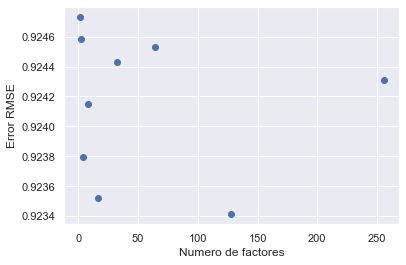

In [175]:
plt.scatter(factores, rmse_test_means)
plt.xlabel('Numero de factores')
plt.ylabel('Error RMSE')
plt.show()

In [64]:
from surprise.model_selection import GridSearchCV

param_grid = {'n_factors': [5,50,100],'n_epochs': [5, 10,20], 'lr_all': [0.001, 0.002, 0.005],
              'reg_all': [0.002, 0.02, 0.2]}
gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3, n_jobs = -1)


In [65]:
gs.fit(data)

In [66]:
print(gs.best_score['rmse'])
print(gs.best_params['rmse'])

0.9218938043108785
{'n_factors': 5, 'n_epochs': 20, 'lr_all': 0.002, 'reg_all': 0.2}


In [67]:
#-----------------------------------------------------------------------------------------------#

In [68]:
n_usuarios=len(data_rev.reset_index(drop=True).iloc[0:1000])
n_items=len(data_games.id)
usuarios=data_rev.iloc[0:1000].username
items=data_games.id

NameError: name 'data_rev' is not defined

In [ ]:
user=data_reviews_ok.username.value_counts()[data_reviews_ok.username.value_counts()>3].index
items=title_id.id.unique()
n_user=len(user)
n_items=len(items)

In [ ]:
matriz_utilidad=pd.DataFrame(np.zeros((n_user,n_items)), index=user, columns=items).astype(pd.SparseDtype('float'))
matriz_utilidad

In [ ]:
for column in matriz_utilidad:
    spdtypes=matriz_utilidad.dtypes[column]
    
    matriz_utilidad[column] = matriz_utilidad[column].sparse.to_dense()
    
    
    mask_calif_columns=items==column
    calificaciones_column=data_reviews_ok.username.value_counts()[data_reviews_ok.username.value_counts()>3]
    
    
    matriz_utilidad[column].loc[calificaciones_column.index]=calificaciones_column
    

In [ ]:
items

In [ ]:
data_reviews_ok[data_reviews_ok.username.value_counts()>3]